In [60]:
import pandas as pd
import numpy as np
import janitor
from pathlib import Path
import missingno
from utils import read_csv_file, DontMissMe
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


In [61]:
%matplotlib inline

sns.set_theme(
    rc={
      "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

In [62]:
data_path = Path("data")
train_path = Path("data", "train.csv")
test_path = Path("data", "test_public.csv")
train_parquet_path = Path("data", "train.parquet")
test_parquet_path = Path("data", "test_public.parquet")

In [63]:
# train_df = pd.read_csv(train_path)  
# test_df = pd.read_csv(test_path)

In [64]:
# train_df.to_parquet(data_path / "train.parquet", index=False)
# test_df.to_parquet(data_path / "test_public.parquet", index=False)

In [65]:
train_df = pd.read_parquet(train_parquet_path)
test_df = pd.read_parquet(test_parquet_path)

In [66]:
numerical_cols = ["AGE", "BMI"]
categorical_cols = list(set(train_df.columns) - set(numerical_cols) - set(["ID"]))
train_df[categorical_cols] = train_df[categorical_cols].astype("category")

In [67]:
# Imputación para valores numéricos
num_imputer = sklearn.impute.SimpleImputer(strategy="median")
cat_imputer = sklearn.impute.SimpleImputer(strategy="most_frequent")


In [68]:
# train_df[numerical_cols] = num_imputer.fit_transform(train_df[numerical_cols])
# train_df[categorical_cols] = cat_imputer.fit_transform(train_df[categorical_cols])

In [69]:
def impute_data(df, fit= True,num_imputer=num_imputer, cat_imputer=cat_imputer):
    if fit:
        df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
        df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])
    else:
        df[numerical_cols] = num_imputer.transform(df[numerical_cols])
        df[categorical_cols] = cat_imputer.transform(df[categorical_cols])
    return df

In [70]:
train_df = impute_data(train_df)
test_df = impute_data(test_df, fit=False)

In [71]:
X_train = train_df.drop(columns=['CHD_OR_MI', 'ID'])
y_train = train_df['CHD_OR_MI']

X_test = test_df.drop(columns=['CHD_OR_MI', 'ID'])
y_test = test_df['CHD_OR_MI']

In [72]:
from imblearn.combine import SMOTEENN

# Balanceo con SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)


In [73]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# train_data = pd.concat([X_train, y_train], axis=1)

# minority_class = train_data[train_data['CHD_OR_MI'] == 0.0]
# majority_class = train_data[train_data['CHD_OR_MI'] == 1.0]

# # Aplicar sobremuestreo en la clase minoritaria
# minority_oversampled = resample(minority_class, 
#                                 replace=True,      # Muestreo con reemplazo
#                                 n_samples=len(majority_class), # Igualar al tamaño de la clase mayoritaria
#                                 random_state=42)

# balanced_train_data = pd.concat([majority_class, minority_class])

# X_train_balanced = balanced_train_data.drop(columns=['CHD_OR_MI'])
# y_train_balanced = balanced_train_data['CHD_OR_MI']


In [74]:
balanced_distribution = y_train_balanced.value_counts(normalize=True)
y_train_balanced.shape, balanced_distribution

((531491,),
 CHD_OR_MI
 0.0    0.590576
 1.0    0.409424
 Name: proportion, dtype: float64)

In [75]:
from imblearn.under_sampling import TomekLinks

# Instanciar el objeto TomekLinks
tomek = TomekLinks()

# Aplicar Tomek Links para reducir la clase mayoritaria
X_train_balanced, y_train_balanced = tomek.fit_resample(X_train_balanced, y_train_balanced)

# Verificar tamaños antes y después
print("Original:", X_train.shape, "Resampled:", y_train_balanced.shape)


Original: (347246, 26) Resampled: (531490,)


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: Unde

Mejor umbral para la clase minoritaria (basado en F1-score): 0.71

Classification Report:
               precision    recall  f1-score   support

         0.0       0.29      0.52      0.37      3532
         1.0       0.95      0.89      0.92     39874

    accuracy                           0.86     43406
   macro avg       0.62      0.70      0.65     43406
weighted avg       0.90      0.86      0.88     43406


ROC-AUC: 0.8362163188051421

PR-AUC: 0.9813959814978725

Confusion Matrix:
 [[ 1832  1700]
 [ 4414 35460]]


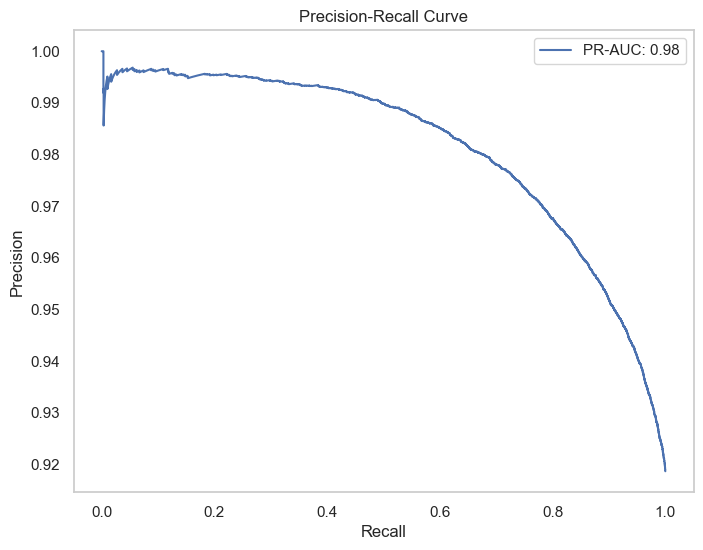

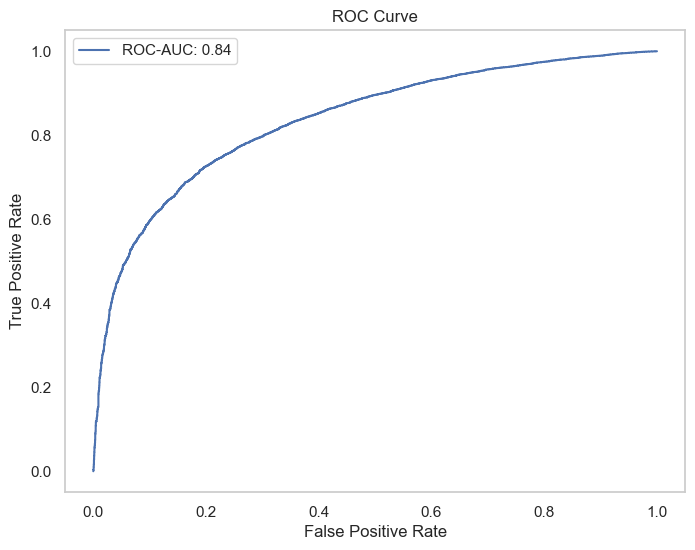

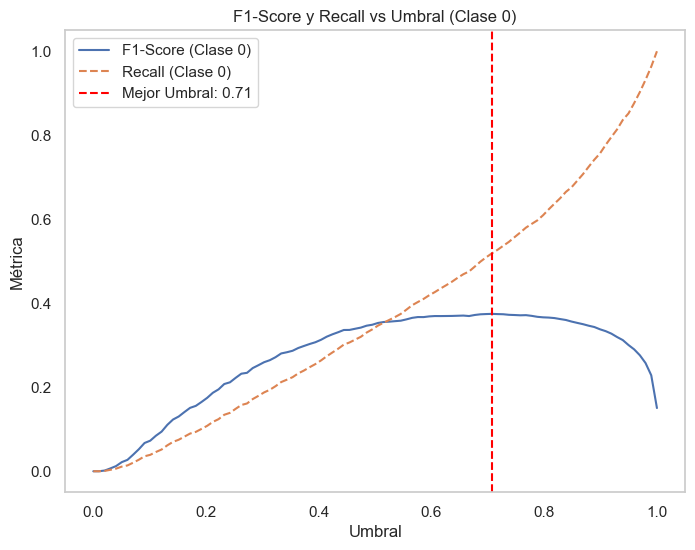

In [78]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve

factor = 3
model = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    scale_pos_weight = len(y_train_balanced[y_train_balanced == 1]) / len(y_train_balanced[y_train_balanced == 0]) * factor,
    random_state=42,
    n_jobs=-1
)


# Entrenamiento del modelo
model.fit(X_train_balanced, y_train_balanced)

# Predicciones de probabilidades
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades

# Optimización del umbral basada en F1-score y Recall para la clase minoritaria
thresholds = np.linspace(0, 1, 100)
f1_scores = []
recalls = []

for threshold in thresholds:
    y_pred_temp = (y_pred_proba >= threshold).astype(int)
    report = classification_report(y_test, y_pred_temp, output_dict=True)
    f1_scores.append(report['0.0']['f1-score'])  # F1-score para la clase 0
    recalls.append(report['0.0']['recall'])  # Recall para la clase 0

# Encontrar el mejor umbral
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Mejor umbral para la clase minoritaria (basado en F1-score): {best_threshold:.2f}")

# Predicciones con el mejor umbral
y_pred = (y_pred_proba >= best_threshold).astype(int)

# Evaluación del modelo con el mejor umbral
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# PR-AUC (Área bajo la curva Precision-Recall)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Resultados
print("\nClassification Report:\n", classification_rep)
print("\nROC-AUC:", roc_auc)
print("\nPR-AUC:", pr_auc)
print("\nConfusion Matrix:\n", conf_matrix)

# Graficar PR-AUC
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR-AUC: {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Graficar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC: {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Graficar F1-Score y Recall vs Umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label="F1-Score (Clase 0)")
plt.plot(thresholds, recalls, label="Recall (Clase 0)", linestyle="--")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Mejor Umbral: {best_threshold:.2f}")
plt.xlabel("Umbral")
plt.ylabel("Métrica")
plt.title("F1-Score y Recall vs Umbral (Clase 0)")
plt.legend()
plt.grid()
plt.show()